<a href="https://colab.research.google.com/github/patprem/SentimentAnalysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis of IMDb Movie Reviews**


Importing the basic and required libraries used in this project

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import random

Mounting personal Google Drive to load the dataset. **IMPORTANT: Change the directory and root path variable accordingly to yours.**

In [ ]:
from google.colab import drive
import sys

#Mount your Google drive to the VM
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/ECE4179 S1 2021 Prathik")

#set a root path variable to use
ROOT = "/content/gdrive/My Drive/ECE4179 S1 2021 Prathik/Final Project"

#Follow link and give permission, copy code and paste in text box
#You only have to do this once per session

Mounted at /content/gdrive


Reading the data from the loaded dataset

**IMPORTANT:** 
1. Download the dataset provided under Datasets section on README.md or download from this links: [IMDB Dataset (csv)](https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data) and [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).
2. Import the downloaded datasets onto your local Google Drive and **change the path variable** accordingly.

In [ ]:
#from google.colab import files
#uploaded = files.upload()
#import io
#dataset = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset.csv']))
# Dataset is now stored in a Pandas Dataframe

# Reading the data from the dataset.
dataset = pd.read_csv('gdrive/My Drive/ECE4179 S1 2021 Prathik/Final Project/IMDB Dataset.csv')

### If you have successfully executed all cells upto this point, then just simply click *Run all* under Runtime tab or press *Ctrl+F9* to execute the remanining cells or follow through the comments besides each cell below to get an understanding of the methodology of this project.

Exploring the loaded dataset

In [ ]:
pd.set_option('display.max_colwidth',2000) # set the column width to 2000 so that we can read the complete review.
pd.set_option('max_rows', 200) 
dataset.head(10) # setting .head(10) to read just the first 10 reviews from the dataset.

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

In [ ]:
dataset.info() # information about the dataset; two columns: review and sentiment,
# where sentiment is the target column or the column that we need to predict.

# number of positive and negative reviews in the dataset.
# dataset is completely balanced and has equal number of positive and negative
# sentiments.
dataset['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


negative    25000
positive    25000
Name: sentiment, dtype: int64

In [ ]:
# reading second review from the dataset and checking how the contents of the review is
# and why we need to use NLP (Natural Language Processing) tasks on this dataset.
review = dataset['review'].loc[10]
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

From the above review (output), we can see that there HTML contents, punctuations, special characters, stopwords and others which do not offer much insight into the prediction of our model. The following NLP tasks (text cleaning technqiues) are implemented.

1.   Eliminating HTML tags/contents like 'br"
2.   Removing punctuations and special characters like |, /, apostrophes, commas and other punctuation marks and etc.
3.   Remove stopwords that do not affect the prediction of our outcome and does not offer much insight such as 'are', 'is', 'the' and etc.
4.   Use Lemmatization to bring back multiple forms of the same word to their common/base root. For example, words like 'ran', 'running', 'runs' to 'run'.
5.   Using Text Tokenization and Vectorization to encode numerical values to our data after the above text cleaning techniques.
6.   Lastly, fit these data to a deep learning model like Convolutional Neural Network (CNN) and LinearSVC model and compare the discrepancies between them






In [ ]:
# Removing HTML contents like "<br>"
# BeautifulSoup is a Python library for extracting data out of HTML and XML files,
# by omitting HTML contents such as "<br>"
from bs4 import BeautifulSoup
soup = BeautifulSoup(review, "html.parser")
review = soup.get_text()
review
# notice that the HTML tags are eliminated.

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.I imagine this film would appeal to a stoner who is currently partaking.For something similar but better try "Brother from another planet"'

In [ ]:
# Removal of other special characters or punctuations except upper or lower case 
# letters using Regular Expressions (Regex)
import re # importing Regex
review = re.sub('\[[^]]*\]', ' ', review) # removing punctuations
review = re.sub('[^a-zA-Z]', ' ', review) # regex; removing strings that contains a non-letter 
# i.e., remove except a-z to A-Z
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines At first it was very odd and pretty funny but as the movie progressed I didn t find the jokes or oddness funny anymore Its a low budget film  thats never a problem in itself   there were some pretty interesting characters  but eventually I just lost interest I imagine this film would appeal to a stoner who is currently partaking For something similar but better try  Brother from another planet '

In [ ]:
# set all characters to lower case for simplicity
review = review.lower()
review

'phil the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines at first it was very odd and pretty funny but as the movie progressed i didn t find the jokes or oddness funny anymore its a low budget film  thats never a problem in itself   there were some pretty interesting characters  but eventually i just lost interest i imagine this film would appeal to a stoner who is currently partaking for something similar but better try  brother from another planet '

Tokenization of reviews in the dataset

In [ ]:
# Tokenization of reviews
# Stopwords removal: Split the text into tokens since stopwords removal 
# works on every word in the text.
review = review.split()
review

['phil',
 'the',
 'alien',
 'is',
 'one',
 'of',
 'those',
 'quirky',
 'films',
 'where',
 'the',
 'humour',
 'is',
 'based',
 'around',
 'the',
 'oddness',
 'of',
 'everything',
 'rather',
 'than',
 'actual',
 'punchlines',
 'at',
 'first',
 'it',
 'was',
 'very',
 'odd',
 'and',
 'pretty',
 'funny',
 'but',
 'as',
 'the',
 'movie',
 'progressed',
 'i',
 'didn',
 't',
 'find',
 'the',
 'jokes',
 'or',
 'oddness',
 'funny',
 'anymore',
 'its',
 'a',
 'low',
 'budget',
 'film',
 'thats',
 'never',
 'a',
 'problem',
 'in',
 'itself',
 'there',
 'were',
 'some',
 'pretty',
 'interesting',
 'characters',
 'but',
 'eventually',
 'i',
 'just',
 'lost',
 'interest',
 'i',
 'imagine',
 'this',
 'film',
 'would',
 'appeal',
 'to',
 'a',
 'stoner',
 'who',
 'is',
 'currently',
 'partaking',
 'for',
 'something',
 'similar',
 'but',
 'better',
 'try',
 'brother',
 'from',
 'another',
 'planet']

Removal of Stopwords

In [ ]:
# importing nltk library to remove stopwords
# Stopwords are words (English language words) that does not add much
# meaning to a sentence. Could be safely ignored without sacrificing the 
# meaning of the sentence or review in this case. Words like 'he', 'have',
# 'the' does not provide any insights.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
review = [word for word in review if not word in set(stopwords.words('english'))]
review

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['phil',
 'alien',
 'one',
 'quirky',
 'films',
 'humour',
 'based',
 'around',
 'oddness',
 'everything',
 'rather',
 'actual',
 'punchlines',
 'first',
 'odd',
 'pretty',
 'funny',
 'movie',
 'progressed',
 'find',
 'jokes',
 'oddness',
 'funny',
 'anymore',
 'low',
 'budget',
 'film',
 'thats',
 'never',
 'problem',
 'pretty',
 'interesting',
 'characters',
 'eventually',
 'lost',
 'interest',
 'imagine',
 'film',
 'would',
 'appeal',
 'stoner',
 'currently',
 'partaking',
 'something',
 'similar',
 'better',
 'try',
 'brother',
 'another',
 'planet']


**Stemming technique**

Stemming is a process to extract the base form of the words by removing affixes from the words.

Both Stemming and Lemmatization technqiues are implemented on a sample review here to observe the discrepancies between them and why Lemmatization is a better algorithm.


In [ ]:
# importing PorterStemmer library to perform stemming
from nltk.stem.porter import PorterStemmer
p_stem = PorterStemmer()
review_p_stem = [p_stem.stem(word) for word in review]
review_p_stem

['phil',
 'alien',
 'one',
 'quirki',
 'film',
 'humour',
 'base',
 'around',
 'odd',
 'everyth',
 'rather',
 'actual',
 'punchlin',
 'first',
 'odd',
 'pretti',
 'funni',
 'movi',
 'progress',
 'find',
 'joke',
 'odd',
 'funni',
 'anymor',
 'low',
 'budget',
 'film',
 'that',
 'never',
 'problem',
 'pretti',
 'interest',
 'charact',
 'eventu',
 'lost',
 'interest',
 'imagin',
 'film',
 'would',
 'appeal',
 'stoner',
 'current',
 'partak',
 'someth',
 'similar',
 'better',
 'tri',
 'brother',
 'anoth',
 'planet']

**Lemmatization technique**

Lemmatization has the same objective as Stemming, however, it takes into consideration the morphological analysis of the words, i.e., it ensures that the root word is a valid English word alphabetically and meaningfully.

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemma = WordNetLemmatizer()
review = [lemma.lemmatize(word) for word in review]
review

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['phil',
 'alien',
 'one',
 'quirky',
 'film',
 'humour',
 'based',
 'around',
 'oddness',
 'everything',
 'rather',
 'actual',
 'punchlines',
 'first',
 'odd',
 'pretty',
 'funny',
 'movie',
 'progressed',
 'find',
 'joke',
 'oddness',
 'funny',
 'anymore',
 'low',
 'budget',
 'film',
 'thats',
 'never',
 'problem',
 'pretty',
 'interesting',
 'character',
 'eventually',
 'lost',
 'interest',
 'imagine',
 'film',
 'would',
 'appeal',
 'stoner',
 'currently',
 'partaking',
 'something',
 'similar',
 'better',
 'try',
 'brother',
 'another',
 'planet']

From the above results, we can notice that there is a huge difference between the techniques used. For example, 'little' has become 'littl' after Stemming, whereas it remained as 'little' after Lemmatization. Stemming tries to achieve a reduction in words to their root form but the stem itself is not a valid English word. Hence, Lemmatization is used in this project.

In [ ]:
# merging the words to form a cleaned up version of the text.
review = ' '.join(review)
review

'phil alien one quirky film humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed find joke oddness funny anymore low budget film thats never problem pretty interesting character eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet'

We can now see that the text is all cleaned up with no HTML tags, punctuations, special characters and stopwords, and it is ready for vectorization and training the model.

**Vectorization of reviews in the dataset**

In [ ]:
# create a corpus to convert the text to mathematical forms or numeric values
corpus = [] # empty vector
corpus.append(review)

Two Vectorization techniques are applied to check the discrepancy between them and the technique with the highest accuracy will be choosen.

1.   CountVectorizer (Bag of Words (BoW) Model)
2.   Tfidf Vectorizer (Bag of Words (BoW) Model)



CountVectorizer (Bag of Words (BoW) Model)

In [ ]:
# importing CountVectorizer to perform vectorization
# Data becomes numeric with 1,2,3s based on the number of times
# they appear in the text
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
review_count_vect = count_vect.fit_transform(corpus) # fitting this technique
# onto the corpus
review_count_vect.toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]])

Tfidf Vectorizer (Bag of Words (BoW) Model)


1.   Text Frequency (TF): how many times a word appears in a review
2.   Inverse Document Frequency (IDF): log(# of text in corpus/# of documents text the term)

TF-IDF score = TF*IDF

In [ ]:
# importing TfidfVectorizer to perform vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# IDF acts as a diminishing factor and diminishes the weights of terms that
# occurs frequently in the text and increases the weights of the terms 
# that occurs rarely.

tfidf_vect = TfidfVectorizer()
review_tfidf_vect = tfidf_vect.fit_transform(corpus)
review_tfidf_vect.toarray()

array([[0.12700013, 0.12700013, 0.12700013, 0.12700013, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.12700013, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.12700013, 0.38100038,
        0.12700013, 0.12700013, 0.25400025, 0.12700013, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.12700013, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.25400025, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.25400025, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.12700013, 0.12700013,
        0.12700013, 0.12700013, 0.12700013, 0.12700013, 0.12700013]])

So far, the techniques mentioned above have been implemented on only one sample review. Now, the above techniques will be applied on all the reviews in the dataset. As there is no test dataset, the dataset is split into 25% of the data as test dataset to test the performance of the model.

In [ ]:
# splitting the dataset into training and test data
# 25% of the data as test dataset and pseudo random generator
# to randomly distribute the reviews to each dataset
from sklearn.model_selection import train_test_split
train_dataset, test_dataset, traindata_label, testdata_label = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.25, random_state=42)
# Convert the sentiments (target column) to numeric forms (1s and 0s) for simplicity
traindata_label = (traindata_label.replace({'positive': 1, 'negative': 0})).values
testdata_label  = (testdata_label.replace({'positive': 1, 'negative': 0})).values

Implementation of text cleaning techniques discussed above on the whole dataset and build the train and test corpus.

In [ ]:
# test and training corpus
train_corpus = []
test_corpus  = []

# text cleaning techniques for training dataset
for i in range(train_dataset.shape[0]):
    soup = BeautifulSoup(train_dataset.iloc[i], "html.parser")
    review = soup.get_text()
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    lemma = WordNetLemmatizer()
    review = [lemma.lemmatize(word) for word in review]
    review = ' '.join(review)
    train_corpus.append(review)
    
# text cleaning techniques for test dataset
for j in range(test_dataset.shape[0]):
    soup = BeautifulSoup(test_dataset.iloc[j], "html.parser")
    review = soup.get_text()
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    lemma = WordNetLemmatizer()
    review = [lemma.lemmatize(word) for word in review]
    review = ' '.join(review)
    test_corpus.append(review)

Validate one sample entry

In [ ]:
# training corpus
train_corpus[1]

'kind movie want good suck first thing hell punk trying school think kid seem realize gravity situation deker guy say girl responsibility ask want go back right give gun wheel chair dude want go alone repair phone line responsibility understand poor actor must pay food give money take make stupid movie like give money charity oh yea none know aim stupid punk guy shoot cafeteria nowhere like crazy want look professional suck one thing believe emergency exit school kid trying several door locked happens fire dumas security guard dead illegal emergency exit school anyway lot say would long spent time life watch crap'

In [ ]:
# test corpus
test_corpus[1]

'many television show appeal quite many different kind fan like farscape know youngster year old fan male female many different country think adore v miniseries element found almost every show v character driven drama could australian soap opera yet episode science fact fiction would give even hardiest trekkie run money brainbender stake wormhole theory time travel true equational form magnificent embrace culture map possibility endless multiple star therefore thousand planet choose broad scope would expected nothing would able keep illusion long farscape really come element succeeds others failed especially like star trek universe practically zero kaos element ran idea pretty quickly kept rehashing course season manage keep audience attention using good continuity constant character evolution multiple thread every episode unique personal touch camera specific certain character group within whole structure allows extremely large area subject matter loyalty forged broken many way many m

Vectorize the training and test corpus using TFIDF technique

In [ ]:
# lower and upper boundary of the range of n-values for different word n-grams to be extracted.
# (1,3) means unigrams and trigrams.
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))
# fitting training corpus and test corpus onto TFIDF Vectorizer
tfidf_vect_train = tfidf_vect.fit_transform(train_corpus)
tfidf_vect_test = tfidf_vect.transform(test_corpus)

**First model: LinearSVC**

In [ ]:
# importing LinearSVC library and fitting the data onto the model
from sklearn.svm import LinearSVC
# C: float; regularization parameter, must be positive.
# random_state: controls pseudo random number generation for
# shuffling data for dual coordinate descent. 
linear_SVC = LinearSVC(C = 0.5, random_state = 42)
linear_SVC.fit(tfidf_vect_train, traindata_label)
predict = linear_SVC.predict(tfidf_vect_test)

LinearSVC with TFIDF Vectorization

In [ ]:
# Check the performance of the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report of LinearSVC model with TFIDF: \n", classification_report(testdata_label, predict,target_names=['Negative','Positive']))
print("Confusion Matrix of LinearSVC with TFIDF: \n", confusion_matrix(testdata_label, predict))
print("Accuracy of LinearSVC with TFIDF: \n", accuracy_score(testdata_label, predict))

Classification Report of LinearSVC model with TFIDF: 
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      6157
    Positive       0.89      0.92      0.91      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500

Confusion Matrix of LinearSVC with TFIDF: 
 [[5467  690]
 [ 524 5819]]
Accuracy of LinearSVC with TFIDF: 
 0.90288


Text(69.0, 0.5, 'Actual Sentiment')

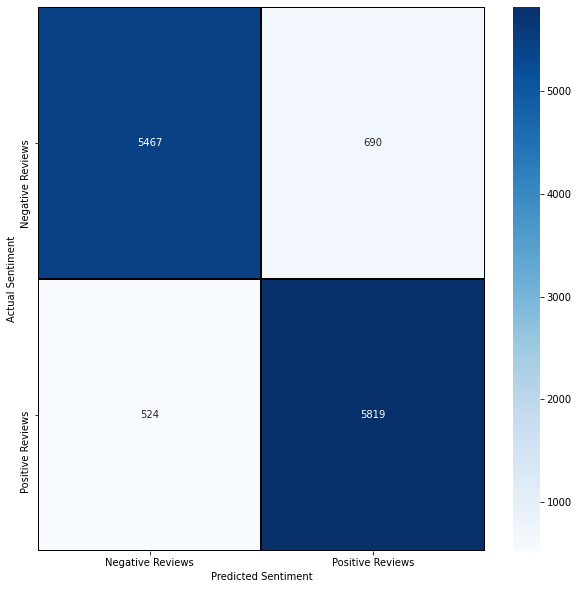

In [ ]:
import seaborn as sns
con_matrix = confusion_matrix(testdata_label, predict)
plt.figure(figsize = (10,10))
sns.heatmap(con_matrix, cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt= '', xticklabels = ['Negative Reviews','Positive Reviews'], yticklabels = ['Negative Reviews','Positive Reviews'])
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")

LinearSVC with CountVectorizer (binary=False) Vectorization

In [ ]:
# fitting the data onto the model using CountVectorizer technique
# binary = False -> If you set binary=True then CountVectorizer no longer uses the counts of terms/tokens.
# If a token is present in a document, it is 1, if absent it is 0 regardless of its frequency of occurrence.
# So you will be dealing with just binary values. By default, binary=False.
# If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
count_vect = CountVectorizer(ngram_range=(1, 3), binary = False) # lower and upper boundary
# of the range of n-values for different word n-grams to be extracted.
# (1,3) means unigrams and trigrams.
count_vect_train = count_vect.fit_transform(train_corpus)
count_vect_test = count_vect.transform(test_corpus)
linear_SVC_count = LinearSVC(C = 0.5, random_state = 42, max_iter = 5000)
linear_SVC_count.fit(count_vect_train, traindata_label)
predict_count = linear_SVC_count.predict(count_vect_test)

In [ ]:
# Check the performance of the model
print("Classification Report of LinearSVC with CountVectorizer: \n", classification_report(testdata_label, predict_count,target_names=['Negative','Positive']))
print("Confusion Matrix of LinearSVC with CountVectorizer: \n", confusion_matrix(testdata_label, predict_count))
print("Accuracy of LinearSVC with CountVectorizer: \n", accuracy_score(testdata_label, predict_count))

Classification Report of LinearSVC with CountVectorizer: 
               precision    recall  f1-score   support

    Negative       0.90      0.89      0.90      6157
    Positive       0.90      0.90      0.90      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500

Confusion Matrix of LinearSVC with CountVectorizer: 
 [[5489  668]
 [ 611 5732]]
Accuracy of LinearSVC with CountVectorizer: 
 0.89768


Text(69.0, 0.5, 'Actual Sentiment')

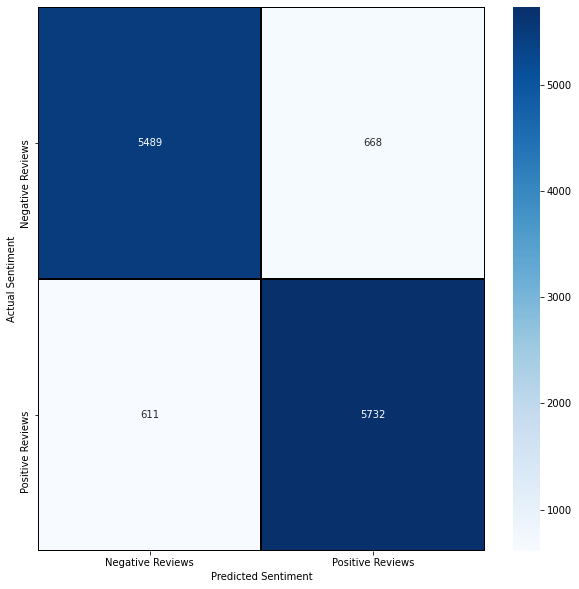

In [ ]:
con_matrix = confusion_matrix(testdata_label, predict_count)
plt.figure(figsize = (10,10))
sns.heatmap(con_matrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Negative Reviews','Positive Reviews'] , yticklabels = ['Negative Reviews','Positive Reviews'])
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")

From the above results, we can observe that **LinearSVC with TFIDF vectorization** gives the maximum accuracy and the outcome on our test dataset can be observed.

In [ ]:
# prediction of data using the above model
predict_dataset = test_dataset.copy()
predict_dataset = pd.DataFrame(predict_dataset)
# setting columns of the predicted outcomes on the dataset
predict_dataset.columns = ['Review']
predict_dataset = predict_dataset.reset_index()
predict_dataset = predict_dataset.drop(['index'], axis=1)
# set the maximum column width to 100000 or more to view the complete review
pd.set_option('display.max_colwidth',100000)
pd.set_option('max_rows', 200)
predict_dataset.head(10)

,Review
0,"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the world title against Lex Luger this match was boring and it has a terrible ending. However it deserves 8/10"
1,"Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you can think of that just adore this T.V miniseries. It has elements that can be found in almost every other show on T.V, character driven drama that could be from an Australian soap opera; yet in the same episode it has science fact & fiction that would give even the hardiest ""Trekkie"" a run for his money in the brainbender stakes! Wormhole theory, Time Travel in true equational form...Magnificent. It embraces cultures from all over the map as the possibilities are endless having multiple stars and therefore thousands of planets to choose from.<br /><br />With such a broad scope; it would be expected that nothing would be able to keep up the illusion for long, but here is where ""Farscape"" really comes into it's own element...It succeeds where all others have failed, especially the likes of Star Trek (a universe with practically zero Kaos element!) They ran out of ideas pretty quickly + kept rehashing them! Over the course of 4 seasons they manage to keep the audience's attention using good continuity and constant character evolution with multiple threads to every episode with unique personal touches to camera that are specific to certain character groups within the whole. This structure allows for an extremely large area of subject matter as loyalties are forged and broken in many ways on many many issues. I happened to see the pilot (Premiere) in passing and just had to keep tuning in after that to see if Crichton would ever ""Get the girl"", after seeing them all on television I was delighted to see them available on DVD & I have to admit that it was the only thing that kept me sane whilst I had to do a 12 hour night shift and developed chronic insomnia...Farscape was the only thing to get me through those extremely long nights...<br /><br />Do yourself a favour; Watch the pilot and see what I mean...<br /><br />Farscape Comet"
2,"The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but that probably would have ended the whole premise for the movie.<br /><br />It seems like they decided to make all kinds of changes in the movie plot, so just plan to enjoy the action, and do not expect a coherent plot. Turn any sense of logic you may have, it will reduce your chance of getting a headache.<br /><br />I does give me some hope that Steven Seagal is trying to move back towards the type of characters he portrayed in his more popular movies."
3,"Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attitude of Emma. She is funny without bein

In [ ]:
# comparing the actual/original label with the predicted label
testactual_label = testdata_label.copy()
testactual_label = pd.DataFrame(testactual_label)
testactual_label.columns = ['Sentiment']
# replacing back the numeric forms of the sentiments to positive and negative respectively
testactual_label['Sentiment'] = testactual_label['Sentiment'].replace({1: 'positive', 0: 'negative'}) 

# predicted sentiments
testpredicted_label = predict.copy()
testpredicted_label = pd.DataFrame(testpredicted_label)
testpredicted_label.columns = ['Predicted Sentiment']
testpredicted_label['Predicted Sentiment'] = testpredicted_label['Predicted Sentiment'].replace({1: 'positive', 0: 'negative'})

In [ ]:
# concatenate the original and predicted labels along with its corresponding review
test_result = pd.concat([predict_dataset, testactual_label, testpredicted_label], axis=1)
pd.set_option('display.max_colwidth',100000)
pd.set_option('max_rows', 200)
test_result.head(10)

,Review,Sentiment,Predicted Sentiment
0,"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the world title against Lex Luger this match was boring and it has a terrible ending. However it deserves 8/10",positive,negative
1,"Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you can think of that just adore this T.V miniseries. It has elements that can be found in almost every other show on T.V, character driven drama that could be from an Australian soap opera; yet in the same episode it has science fact & fiction that would give even the hardiest ""Trekkie"" a run for his money in the brainbender stakes! Wormhole theory, Time Travel in true equational form...Magnificent. It embraces cultures from all over the map as the possibilities are endless having multiple stars and therefore thousands of planets to choose from.<br /><br />With such a broad scope; it would be expected that nothing would be able to keep up the illusion for long, but here is where ""Farscape"" really comes into it's own element...It succeeds where all others have failed, especially the likes of Star Trek (a universe with practically zero Kaos element!) They ran out of ideas pretty quickly + kept rehashing them! Over the course of 4 seasons they manage to keep the audience's attention using good continuity and constant character evolution with multiple threads to every episode with unique personal touches to camera that are specific to certain character groups within the whole. This structure allows for an extremely large area of subject matter as loyalties are forged and broken in many ways on many many issues. I happened to see the pilot (Premiere) in passing and just had to keep tuning in after that to see if Crichton would ever ""Get the girl"", after seeing them all on television I was delighted to see them available on DVD & I have to admit that it was the only thing that kept me sane whilst I had to do a 12 hour night shift and developed chronic insomnia...Farscape was the only thing to get me through those extremely long nights...<br /><br />Do yourself a favour; Watch the pilot and see what I mean...<br /><br />Farscape Comet",positive,positive
2,"The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but that probably would have ended the whole premise for the movie.<br /><br />It seems like they decided to make all kinds of changes in the movie plot, so just plan to enjoy the action, and do not expect a coherent plot. Turn any sense of logic you may have, it will reduce your chance of getting a headache.<br /><br />I does give me some hope that Steven Seagal is trying to move back towards the type of characters he portrayed in his more popular movies.",negative,negative
3,"Jane Austen would definitely approve of this one!<br /><br />Gwyneth P

**Second model: Convolutional Neural Network (CNN)**

Using CNN to conduct sentiment analysis

Preparing the data using a different dataset

In [ ]:
n = 1234
random.seed(n)
np.random.seed(n)
torch.manual_seed(n)
torch.backends.cudnn.deterministic = True
# for convolutional layers
# batch dimension is first
# 'batch_first = true' argument used to tell torchtext to return the permuted data
# in CNN, batch dimension is first, so no need to permute data as 'batch_first' is set to true in TEXT field

TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
# splitting the dataset into training and test data
train_dataset, test_dataset = datasets.IMDB.splits(TEXT, LABEL)
train_dataset, valid_dataset = train_dataset.split(random_state = random.seed(n))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 15.8MB/s]


In [ ]:
# building the vocabulary and loading the pre-trained word embeddings
MAX_VOCAB_SIZE = 25_000

In [ ]:
TEXT.build_vocab(train_dataset, max_size = MAX_VOCAB_SIZE, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_dataset)

.vector_cache/glove.6B.zip: 862MB [04:04, 3.53MB/s]                           
100%|█████████▉| 399916/400000 [00:20<00:00, 18586.52it/s]

In [ ]:
# creating the iterators
# batch size of 64 is used
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_dataset, valid_dataset, test_dataset), batch_size = BATCH_SIZE, device = device)

In [ ]:
# checking the number of reviews in training, test and validation datasets 
print(f'Training reviews: {len(train_dataset)}')
print(f'Validation reviews: {len(valid_dataset)}')
print(f'Testing reviews : {len(test_dataset)}')

Training reviews: 17500
Validation reviews: 7500
Testing reviews : 25000


Building a CNN for the dataset (Text is 1 dimensional)

1.   Convert words into word embeddings to visualize words in 2 dimensions, each word along one axis and other axis for the elements of vectors.
2.   Use a filter size of [n*width]. 'n' is the number of sequential words (n-grams, number of tokens in the review) and width is the dimensions of the word or dimensional embeddings (depth of filter).
3.   Bi-grams are filters that covers two words at a time, tri-grams covers three words and so on. And each element of the filter has a weight associated with it.
4.   The output of this filter is the weighted sum of all elements covered by the filter (single real number). Similarly, the filter moves to cover the next bi-gram and another output is calculated and so on.
5.   This is an example of one such filter. CNNs has a plethora of these filters. The main idea is that each filter will learn a different feature to extract. For example, each of the [2*width] filters looks for the occurence of different bi-grams that are relevant for analysing sentiment of movie reviews. And the same goes for different sizes of filters (n-grams) with heights of 3,4,5 etc. 
6.   Then, use max pooling on the output of the convolutional layers, which takes the maximum value over a dimension. 
7.   The maximum value is the most important feature for determining the sentiment of the review, which corresponds to the most essential n-gram within the review. Through backpropagation, the weights of the filters are updated so that whenever certain n-grams that are highly indicative of the sentiment are seen, the output of the filter is a high or the highest value amongst all. This high value is then passed through the max pooling layer if it is the maximum value in the output.
8.   This model has 100 filters of 3 different sizes (n-grams), i.e., 300 different n-grams. Later, these are concatenated into a single vector and passed through a linear layer to predict the sentiment.
9.   Most importantly, input review has to be atleast as long as the largest filter height used. 



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# implementing the convolutional layers (nn.Conv2d)
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        
        # in_channels: number of channels in text/image fed into convolutional layer
        # in text, only one single channel
        # in_channels: number of filters
        # kernel_size: size of filters (n*emb_dim); n is the size of n-grams 
        # and emb_dim is the dimensional embedding or width of the text
        super().__init__()        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)        
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[0], embedding_dim))        
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (filter_sizes[1], embedding_dim))        
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = n_filters,  kernel_size = (filter_sizes[2], embedding_dim))        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)        
        self.dropout = nn.Dropout(dropout)        
        
    def forward(self, text):

        # pass review to an embedding layer to get embeddings    
        # second dimension of the input to nn.Conv2d is the channel dimension         
        embed_done = self.embedding(text) 

        # text has no channel dimension, so unsqueeze to make one
        # and matches with in_channels (=1) dimension       
        embed_done = embed_done.unsqueeze(1)     

        # pass tensors through convolutional and pooling layers using ReLU
        # (non-linearity) activation function after the conv layers
        conv_layer0 = F.relu(self.conv_0(embed_done).squeeze(3))
        conv_layer1 = F.relu(self.conv_1(embed_done).squeeze(3))
        conv_layer2 = F.relu(self.conv_2(embed_done).squeeze(3))

        # pooling layers handles reviews of different lengths
        # with max pooling, input to linear layer is the total no. of filters
        max_pool0 = F.max_pool1d(conv_layer0, conv_layer0.shape[2]).squeeze(2)
        max_pool1 = F.max_pool1d(conv_layer1, conv_layer1.shape[2]).squeeze(2)
        max_pool2 = F.max_pool1d(conv_layer2, conv_layer2.shape[2]).squeeze(2)
       
        # output size of conv layers depends on the input size
        # different batches contains reviews of different lengths 
        # lastly, apply dropout on the concatenated filter outputs 
        concatenation = self.dropout(torch.cat((max_pool0, max_pool1, max_pool2), dim = 1))

        # pass through a linear layer (fully-connected layer) to make predictions
        return self.fc(concatenation)

The above CNN uses only 3 different sized filters. The below code is a generic CNN that takes in any number of filters.

In [ ]:
# place all conv layers in a nn.ModuleList - function in PyTorch to hold a list
# of PyTorch nn.Module

# pass arbitrary sized list of filter sizes (generic model) 
# creates a conv layer for each
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):        
        super().__init__()                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (fs, embedding_dim)) for fs in filter_sizes])        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)        
        self.dropout = nn.Dropout(dropout)

    # iterate through the list applying each conv layer to get a list of
    # conv outputs which is fed into max pooling layer in a list
    # comprehension before concatenation and passing through dropout
    # and linear layers        
    def forward(self, text):
        embed_done = self.embedding(text)      
        embed_done = embed_done.unsqueeze(1)               
        conv_layer_relu = [F.relu(conv(embed_done)).squeeze(3) for conv in self.convs]                
        max_pool_drop = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_layer_relu]
        concatenation = self.dropout(torch.cat(max_pool_drop, dim = 1))
        return self.fc(concatenation)

Creating an instance of our CNN model 

In [ ]:
dimension_input = len(TEXT.vocab)
# dimensional embeddings
dimn_embedding = 100
# number of filters
number_filters = 100
# size of the filters
size_filter = [3,4,5]
# output size
dimension_output = 1
# dropout (value of 'p')
p = 0.5
# padding
padding = TEXT.vocab.stoi[TEXT.pad_token]
# applying all these to the CNN
model = CNN(dimension_input, dimn_embedding, number_filters, size_filter, dimension_output, p, padding)

# check number of parameters in CNN model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


Loading the pre-trained embeddings

In [ ]:
embed_pretrain = TEXT.vocab.vectors
# weights
model.embedding.weight.data.copy_(embed_pretrain)

# zero the initial weights of the unknown and padding tokens
token = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[token] = torch.zeros(dimn_embedding)
model.embedding.weight.data[padding] = torch.zeros(dimn_embedding)

Next, now it is ready to train our model. The optimizer and loss function (criterion) are initialized. Here, I have used the ADAM optimizer and Binary Cross Entropy with Logits Loss function.

In [ ]:
# importing ADAM optimizer
import torch.optim as optim
# set ADAM optimizer
optimizer = optim.Adam(model.parameters())
# set the loss function
criterion = nn.BCEWithLogitsLoss()
# set model and criterion on GPU
model = model.to(device)
criterion = criterion.to(device)

Implementing a function to calculate accuracy in order to check the performance of the model

In [ ]:
# returns accuracy per batch, will return, for example, 0.8 instead of 8.
def binary_accuracy(preds, y):
  # rounds predictions to the closest integer
    predictions_rounded = torch.round(torch.sigmoid(preds))
    true_prediction = (predictions_rounded == y).float() # float better for division purposes
    accuracy = true_prediction.sum() / len(true_prediction)
    return accuracy 

In [ ]:
# function for training the model
def train(model, iterator, optimizer, criterion):
    # initialise the epoch loss and accuracy
    epoch_accuracy = 0 
    epoch_loss = 0
    model.train() # to ensure dropout is turned ON while training
    
    for batch in iterator:        
        optimizer.zero_grad()        
        predictions = model(batch.text).squeeze(1)        
        loss = criterion(predictions, batch.label)        
        accuracy  = binary_accuracy(predictions, batch.label)        
        loss.backward()        
        optimizer.step()        
        epoch_loss += loss.item()
        epoch_accuracy  += accuracy .item()        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

In [ ]:
# function for testing the model
def evaluate(model, iterator, criterion):
    # initialise the epoch loss and accuracy
    epoch_loss = 0
    epoch_accuracy = 0    
    model.eval() # to ensure dropout is turned OFF while evaluating/testing
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)            
            loss = criterion(predictions, batch.label)            
            accuracy = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

In [ ]:
# importing time library to define function to tell the time taken of our
# epochs 
import time
def epoch_time(start_time, end_time):
    time_taken = end_time - start_time
    time_taken_mins = int(time_taken / 60)
    time_taken_secs = int(time_taken - (time_taken_mins * 60))
    return time_taken_mins, time_taken_secs

**Training the CNN model**

In [ ]:
# 5 epochs are enough to view the values of loss and accuracy
number_epochs = 5
good_validationloss = float('inf') # set to float
for epoch in range(number_epochs):
    start_time = time.time()    
    # calculating the training loss and accuracy and the validation loss
    # and accuracy
    train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_accuracy = evaluate(model, valid_iterator, criterion)    
    end_time = time.time()
    epoch_minutes, epoch_secs = epoch_time(start_time, end_time)    
    if valid_loss < good_validationloss:
        good_validationloss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    # print the training loss and accuracy and validation loss and accuracy
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_minutes}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_accuracy*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 31s
	Train Loss: 0.427 | Train Acc: 80.43%
	 Val. Loss: 0.366 |  Val. Acc: 83.63%
Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 0.297 | Train Acc: 87.73%
	 Val. Loss: 0.327 |  Val. Acc: 86.32%
Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.218 | Train Acc: 91.40%
	 Val. Loss: 0.339 |  Val. Acc: 86.17%
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.150 | Train Acc: 94.47%
	 Val. Loss: 0.324 |  Val. Acc: 87.12%
Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.105 | Train Acc: 96.52%
	 Val. Loss: 0.348 |  Val. Acc: 86.97%


This function will prompt the user to input their reviews. Based on the review, the model will the predict whether the sentiment of the review is positive or negative along with how accurate the model predicts the sentiment.

In [ ]:
import spacy
prompt = spacy.load('en_core_web_sm')

# minimum_length is set to 10000 so that utmost 10000 tokens are accepted for computing
# the outcome, i.e., 10000 words in a review which is more than enough
def classify_predict_sentiment(model, sentence, minimum_length = 10000):
    model.eval()
    tokenization_done = [tok.text for tok in prompt.tokenizer(sentence)]
    # classify_predict_sentiment function accepts minimum length argument also by changing
    # minimum_length
    # If tokenization_done input sentence is less than minimum_length tokens, then we append
    # padding tokens ('<pad>') to make it minimum_length tokens
    if len(tokenization_done) < minimum_length:
        tokenization_done += ['<pad>'] * (minimum_length - len(tokenization_done))
    indexing = [TEXT.vocab.stoi[t] for t in tokenization_done]
    box = torch.LongTensor(indexing).to(device)
    box = box.unsqueeze(0)
    prediction = torch.sigmoid(model(box))
    
    # if the accuracy of the review is less than 0.5, it shall be considered
    # a negative review and anything above 0.5 shall be considered a positive
    # review
    if prediction.item() < 0.5:
      print(f'Negative Review')
    else:
      print(f'Positive Review')

    return print(f'Accuracy of this review: {prediction.item():.8f}')

The following positive and negative reviews are fed into the model and the outcome is displayed along with the accuracy from the model, i.e., how accurate the model predicts whether it is a positive or negative review.

In [ ]:
classify_predict_sentiment(model, "I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her sexy image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than Devil Wears Prada and more interesting than Superman a great comedy to go see with friends.")

Positive Review
Accuracy of this review: 0.91910881


In [ ]:
classify_predict_sentiment(model, "This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air.")

Negative Review
Accuracy of this review: 0.00040174


In [ ]:
classify_predict_sentiment(model, "This a fantastic movie of three prisoners who become famous. One of the actors is george clooney and I'm not a fan but this roll is not bad. Another good thing about the movie is the soundtrack (The man of constant sorrow). I recommand this movie to everybody. Greetings Bart")

Positive Review
Accuracy of this review: 0.97659189


In [ ]:
classify_predict_sentiment(model,"I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday afternoons, I still was tired of the formula for these monster type movies that usually included the hero, a beautiful woman who might be the daughter of a professor and a happy resolution when the monster died in the end. I didn't care much for the romantic angle as a 12 year old and the predictable plots. I love them now for the unintentional humor.<br /><br />But, about a year or so later, I saw Psycho when it came out and I loved that the star, Janet Leigh, was bumped off early in the film. I sat up and took notice at that point. Since screenwriters are making up the story, make it up to be as scary as possible and not from a well-worn formula. There are no rules.")

Negative Review
Accuracy of this review: 0.03677244


In [ ]:
classify_predict_sentiment(model,"The Karen Carpenter Story shows a little more about singer Karen Carpenter's complex life. Though it fails in giving accurate facts, and details.<br /><br />Cynthia Gibb (portrays Karen) was not a fine election. She is a good actress , but plays a very naive and sort of dumb Karen Carpenter. I think that the role needed a stronger character. Someone with a stronger personality.<br /><br />Louise Fletcher role as Agnes Carpenter is terrific, she does a great job as Karen's mother.<br /><br />It has great songs, which could have been included in a soundtrack album. Unfortunately they weren't, though this movie was on the top of the ratings in USA and other several countries.")

Positive Review
Accuracy of this review: 0.98216945


In [ ]:
classify_predict_sentiment(model,"I watched this film not really expecting much, I got it in a pack of 5 films, all of which were pretty terrible in their own way for under a fiver so what could I expect? and you know what I was right, they were all terrible, this movie has a few (and a few is stretching it) interesting points, the occasional camcorder view is a nice touch, the drummer is very like a drummer, i.e damned annoying and, well thats about it actually, the problem is that its just so boring, in what I can only assume was an attempt to build tension, a whole lot of nothing happens and when it does its utterly tedious (I had my thumb on the fast forward button, ready to press for most of the movie, but gave it a go) and seriously is the lead singer of the band that great looking, coz they don't half mention how beautiful he is a hell of a lot, I thought he looked a bit like a meercat, all this and I haven't even mentioned the killer, I'm not even gonna go into it, its just not worth explaining. Anyway as far as I'm concerned Star and London are just about the only reason to watch this and with the exception of London (who was actually quite funny) it wasn't because of their acting talent, I've certainly seen a lot worse, but I've also seen a lot better. Best avoid unless your bored of watching paint dry.")

Negative Review
Accuracy of this review: 0.00015149
